<a href="https://colab.research.google.com/github/prathmesh0203/simulation/blob/master/Unmanaged_Diagnose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pulp

total unmanaged SOC: 34.383973756255145
start managed charging
total v1g soc: 26.30501381429754
Infeasible
Maximum of EV load: 1608.4 kW
Peak load: 1608.4 kW
Increases in peak load: 1608.4 kW
Peak valley difference: 1606.8 kW
Utilization factor: 40%
Increased capacity required: -1592.0 kW


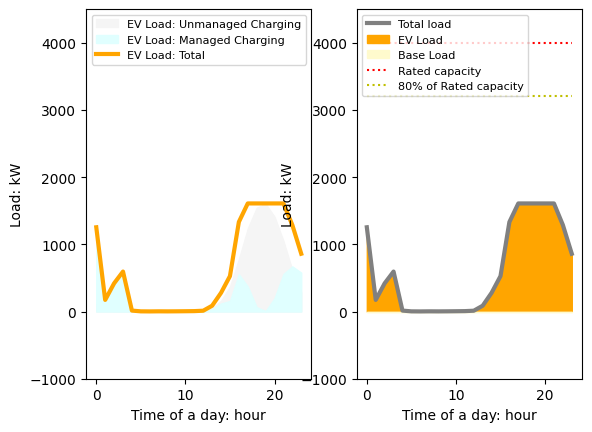

In [5]:
import numpy as np
import pulp as lp
import re
from matplotlib import pyplot as plt
from queue import PriorityQueue
import pandas as pd

def user_definedProb(Charge_Freq,values):
    totalFreq = sum(Charge_Freq)
    Charge_Prob = [x / totalFreq for x in Charge_Freq]
    Charge_Prob_new = np.zeros(1440)
    values_interval = np.int_([x * 60 for x in values])
    j = 0
    for j in range(24): #changed 16 into 24
        if j < 23: #changed 15 into 23
            index_bottom = values_interval[j]
            index_upper = values_interval[j + 1]
            Charge_Prob_new[index_bottom:index_upper] = Charge_Prob[j]
        if j == 23: #changed 16 into 23
            index_bottom = values_interval[0]
            Charge_Prob_new[0:index_bottom] = Charge_Prob[j]
            index_upper = values_interval[j]
            if index_upper < 1440:
                Charge_Prob_new[index_upper:1440] = Charge_Prob[j]
    totalFreq = sum(Charge_Prob_new)
    Charge_Prob_new2 = [x / totalFreq for x in Charge_Prob_new]
    return Charge_Prob_new2

def getArrivalTime(nVech): # starting time is defined by users as an input
    if useCase ==1: #residential
        ###default value and user defined input, e.g., (20,2) to (19, 2.5)
        arrivalTime = np.random.normal(20, 1, nVech)
        return arrivalTime
    if useCase==2:  #office
        ####default value
        arrivalTime = np.random.lognormal(2.32274, 0.301833, nVech)
        return arrivalTime
        #### user defined input: e.g., (9,2) to (8.5, 1.5)
        arrivalTime = np.random.normal(9, 2, nVech)
        return arrivalTime
    if useCase==3: #public
        ####fixed, don't allow for changes
        Arrival_Freq = [407.1, 439.5, 502.7, 557.2, 664.4, 874.9, 1109.4, 1773.9,
                       1974.6, 2073.7, 2080.1, 2098.3, 2110.6, 2113.4, 2116.8, 2110.1,
                       2104.5, 2086.1, 2082.2, 2079.9, 2055.3, 1944.7, 1606.2, 367.1]
        values = [1, 2, 3, 4,  5, 6, 7, 8,
                  9, 10, 11, 12, 13, 14, 15, 16,
                  17, 18, 19, 20, 21, 22, 23,24]
        values_new = range(1440)
        Charge_Prob_new2 = user_definedProb(Arrival_Freq, values)
        arrivalTime = np.random.choice(values_new, nVech, p=list(Charge_Prob_new2))
        return arrivalTime / 60
    if useCase==4: #user defined
        #user defined: option 1-- 24 elements of Arrival Freq
        Arrival_Freq = [507, 422, 401, 420, 508,634, 898, 1390, 1913, 2187,2363,2363,
                        2139, 1939, 1821, 1621, 1521, 1335, 1311, 603,600,563, 503,503]
        #Arrival_Freq = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        #                0, 0, 0, 0, 0, 0, 24, 12,7,1, 1,1]
        values=range(24)
        values_new = range(1440)
        Charge_Prob_new2=user_definedProb(Arrival_Freq,values)
        #arrivalTime = np.random.choice(values_new, nVech, p=list(Charge_Prob_new2))
        #return arrivalTime / 60

        #user defined: option 2--e.g, (18,1.5) to (17, 2)
        arrivalTime=np.random.normal(18,2, nVech)
        return arrivalTime


def getStartingSOC(isSlow, n_Veh): # SOC is defined by charging frequencies
    if isSlow == 1: # slow charge: one charge per day
        dist_list = np.random.lognormal(3.67017251945698, 0.532230403897875, n_Veh)
        startingSOC = 1 - dist_list / batteryRange
        return startingSOC

    if isSlow > 1: # fast charge: multiple days per charge
        if useCase==1 or useCase==2: # resiential & office: 'mileages traveled' approach
            dist_list = np.random.lognormal(3.67017251945698, 0.532230403897875, n_Veh)
            for i in range(n_Veh):
                dist_list[i] = dist_list[i] * Charge_frequency
                if dist_list[i] > batteryRange * 0.8:  #cannot be below 20%SOC
                    while True:
                        dist_list[i] = np.random.lognormal(3.67017251945698, 0.532230403897875, 1)
                        dist_list[i] = dist_list[i] * Charge_frequency
                        if dist_list[i] <= batteryRange * 0.8:
                            break
            startingSOC = 1 - dist_list / batteryRange
            return startingSOC
        if useCase==3: # commercial & public: 'predefined starting SOC':
            startingSOC = np.random.beta(1.37722, 3.42153, n_Veh)
            return startingSOC

    if useCase==4: #user defined starting SOC: SOC is a value between 0 and 1. e.g., (0.6, 0.2) to (0.2, 0.3)
        startingSOC=np.random.normal(0.4,0.2, n_Veh)
        return startingSOC

def time24(time):
    condlist = [time< 2160, time >=2160]
    choicelist= [time, -1]
    time=np.select(condlist, choicelist)

    condlist = [time < 1440, time >= 1440]
    choicelist = [time, time - 1440]
    time = np.select(condlist, choicelist)
    return time


def Unmanaged_charge(n_Veh, power, nChargers):
    iterator=range(n_iter)
    Load_maxtrix = np.zeros((n_iter, Maxtime_Interval))
    endSOC=1

    for it in iterator:
        eLoad=np.zeros(Maxtime_Interval)

        startingSOC=getStartingSOC(isSlow,n_Veh)
        charge_Duration=(endSOC-startingSOC) * batteryCapacity/power/charge_efficiency*60
        condlist = [charge_Duration < 0, charge_Duration >= 0]
        choicelist = [0, charge_Duration]
        charge_Duration = np.select(condlist, choicelist)

        arrivalTime = getArrivalTime(n_Veh)
        arrivalTime.sort()
        arrivalTime = np.int_(np.round(arrivalTime * 60))

        # calculate the charging starting time based on the queuing size, that is, limited number of chargers
        startingTime = np.zeros(n_Veh)
        endTime = np.zeros(n_Veh)
        startingTime[:nChargers] = arrivalTime[:nChargers]
        endTime[:nChargers] = np.int_(
            np.around(startingTime[:nChargers] + charge_Duration[:nChargers]))

        q = PriorityQueue()
        for i in range(0, nChargers):  # initiate the queue
            q.put(endTime[i])
        for i in range(nChargers, len(arrivalTime)):
            non_available = [j for j in q.queue if j > arrivalTime[i]]
            # print('que status', q.queue)
            if len(non_available) == nChargers:
                startingTime[i] = np.int_(min(non_available)) + 1
                q.get()
            else:
                startingTime[i] = np.int_(arrivalTime[i])
                q.get()
            endTime[i] = np.int_(np.around(startingTime[i] + charge_Duration[i]))
            q.put(endTime[i])

        waitTime = startingTime - arrivalTime
        startingTime = time24(startingTime)
        endTime = time24(endTime)
        startingTime = [int(i) for i in startingTime]
        endTime = [int(i) for i in endTime]
        for i in range(0, len(waitTime)):
            if endTime[i] == -1:
                waitTime[i] = 0
        avgwait = np.mean(waitTime)
        unChargedveh = endTime.count(-1)
        # print('arrival time', arrivalTime)
        # print('starting time', startingTime)
        # print('end time', endTime)
        # print('wait time', waitTime)
        # print('average wait time for slow chargers is %5.2f hours' %avgwaitSlow)
        # print('%4d vehicles uncharged due to lack of slow chargers' %unChargedveh_slow)

        for c in range(n_Veh):
            if endTime[c] ==-1 or startingTime[c] ==-1:
                break
            if endTime[c]>startingTime[c]:
                iterator_time=np.arange(startingTime[c]-1,endTime[c],1)
                for t in iterator_time:
                    eLoad[t]= eLoad[t]+power
            else:
                iterator_time=np.arange(startingTime[c]-1, Maxtime_Interval,1)
                for t in iterator_time:
                    eLoad[t]=eLoad[t]+power
                iterator_time=np.arange(0,endTime[c],1)
                for t in iterator_time:
                    eLoad[t]=eLoad[t]+power
        Load_maxtrix[it]=eLoad

    Load_avg=Load_maxtrix.mean(0)
    Load_var=Load_maxtrix.std(0)
    Load_upper=Load_avg+Load_var*2
    Load_bottom=Load_avg-Load_var*2

    totalsoc=sum(startingSOC)
    print('total unmanaged SOC:', totalsoc)

    return Load_avg, Load_bottom, Load_upper, avgwait

def Unmanaged_usecase(useCase):
    avgwaitSlow = -1
    avgwaitFast = -1
    avgwaitGen = -1

    if useCase==1:
        Load_avg, Load_bottom, Load_upper, avgwait=Unmanaged_charge(n_slowVeh, power_Slow, nslow_Chargers)
        avgwaitSlow=avgwait
        iterator_time=range(24)
        for t in iterator_time:
            slow_Load_1h_avg[t]=np.average(Load_avg[t*60:(t+1)*60])
        slow_Load_1h_upper=np.zeros(24)
        for t in iterator_time:
            slow_Load_1h_upper[t]=np.average(Load_upper[t*60:(t+1)*60])
        slow_Load_1h_bottom=np.zeros(24)
        for t in iterator_time:
            slow_Load_1h_bottom[t]=np.average(Load_bottom[t*60:(t+1)*60])

        Load_avg, Load_bottom, Load_upper, avgwait=Unmanaged_charge(n_fastVeh, power_Fast, nfast_Chargers)
        avgwaitFast = avgwait
        iterator_time=range(24)
        for t in iterator_time:
            fast_Load_1h_avg[t]=np.average(Load_avg[t*60:(t+1)*60])
        fast_Load_1h_upper=np.zeros(24)
        for t in iterator_time:
            fast_Load_1h_upper[t]=np.average(Load_upper[t*60:(t+1)*60])
        fast_Load_1h_bottom=np.zeros(24)
        for t in iterator_time:
            fast_Load_1h_bottom[t]=np.average(Load_bottom[t*60:(t+1)*60])

    if useCase==2 or useCase==3:
        Load_avg, Load_bottom, Load_upper, avgwait=Unmanaged_charge(n_fastVeh, power_Fast, nfast_Chargers)
        avgwaitFast = avgwait
        iterator_time=range(24)
        for t in iterator_time:
            fast_Load_1h_avg[t]=np.average(Load_avg[t*60:(t+1)*60])
        fast_Load_1h_upper=np.zeros(24)
        for t in iterator_time:
            fast_Load_1h_upper[t]=np.average(Load_upper[t*60:(t+1)*60])
        fast_Load_1h_bottom=np.zeros(24)
        for t in iterator_time:
            fast_Load_1h_bottom[t]=np.average(Load_bottom[t*60:(t+1)*60])

    if useCase==4:
        Load_avg, Load_bottom, Load_upper, avgwait=Unmanaged_charge(n_V0G_Veh, power_General, ngen_Chargers) #please change into n_fastVeh
        avgwaitGen = avgwait
        iterator_time=range(24)
        for t in iterator_time:
            gen_Load_1h_avg[t]=np.average(Load_avg[t*60:(t+1)*60])
        gen_Load_1h_upper=np.zeros(24)
        for t in iterator_time:
            gen_Load_1h_upper[t]=np.average(Load_upper[t*60:(t+1)*60])
        gen_Load_1h_bottom=np.zeros(24)
        for t in iterator_time:
            gen_Load_1h_bottom[t]=np.average(Load_bottom[t*60:(t+1)*60])

    return avgwaitSlow, avgwaitFast, avgwaitGen

def initiate_V1G(n_V1G_Veh): # initiate the initial state (including SOC, parking duration) for managed charging vehicles
    # process startingTime and endingTime for each V1G vehicle
    v1g_startingTime = getArrivalTime(n_V1G_Veh)
    condlist = [v1g_startingTime < 24, v1g_startingTime >= 24]
    choicelist = [v1g_startingTime, v1g_startingTime - 24]
    startingTime1 = np.select(condlist, choicelist)
    v1g_startingTime = np.int_(np.round(startingTime1))

    temp_start = np.int_(np.round(startingTime1))
    temp_park_random = np.zeros(n_V1G_Veh)
    for i in range(n_V1G_Veh):
        temp_park = parking_Duration[temp_start[i] - 1]
        temp_park_random[i] = np.random.normal(temp_park, 0.5, 1)[0]
    v1g_endingTime = temp_start + temp_park_random
    condlist = [v1g_endingTime < 24, v1g_endingTime >= 24]
    choicelist = [v1g_endingTime, v1g_endingTime - 24]
    endingTime1 = np.select(condlist, choicelist)
    v1g_endingTime = np.int_(np.round(endingTime1))

    # process startingSOC and travel distance for each V1G vehicle
    v1g_startingSOC = getStartingSOC(2, n_V1G_Veh)
    v1g_startingSOC = getStartingSOC(isSlow,n_V1G_Veh) ## please use this equation instead

    totalsoc=sum(v1g_startingSOC)
    print('total v1g soc:', totalsoc)
    #v1g_distance = np.random.lognormal(3.67017251945698, 0.532230403897875, n_V1G_Veh)
    #v1g_startingSOC = sorted(v1g_startingSOC)
    #v1g_distance = sorted(v1g_distance)
    #for i in range(n_V1G_Veh):
    #    startSOC_temp = 1 - v1g_distance[i] / batteryRange
    #    if startSOC_temp < v1g_startingSOC[i]:
    #        v1g_startingSOC[i] = startSOC_temp

    return v1g_startingTime, v1g_endingTime, v1g_startingSOC

def V1G_optimization(): #this is the function for managed charging

    # initiate the problem statement
    model=lp.LpProblem('Minimize_Distribution_level_Peak_Valley_Difference', lp.LpMinimize)

    #define optimization variables
    veh_V1G=range(n_V1G_Veh)
    time_Interval=range(24)

    chargeprofiles=lp.LpVariable.dicts('charging_profiles', ((i,j) for i in veh_V1G for j in time_Interval), lowBound=0.1, upBound=power_V1GUppper)
    chargestates=lp.LpVariable.dicts('charging_states', ((i,j) for i in veh_V1G for j in time_Interval), cat='Binary')
    total_load=lp.LpVariable.dicts('total_load', time_Interval,lowBound=0.1)
    max_load=lp.LpVariable('max_load', lowBound=0)
    min_load=lp.LpVariable('min_load', lowBound=0)

    # define objective function
    model += max_load - min_load
    #model += max_load

    # define constraints
    for t in time_Interval: # constraint 1 & 2: to identify the max and min loads
        model += total_load[t] <= max_load
        model += total_load[t] >= min_load

    for t in time_Interval: # constraint 3: calculate the total load at each time interval t
        if opt_includeSolar == 0:
            model += lp.lpSum( [chargeprofiles[i,t]] for i in veh_V1G) + base_Load[t] + unmanaged_Load[t] == total_load[t]
        else:
            model += lp.lpSum([chargeprofiles[i, t]] for i in veh_V1G) + base_Load[t] + unmanaged_Load[t] - solarCurve[t] == total_load[t]

    for i in veh_V1G: # constraint 4: constraint on charging powers for each EV: only optimize the charge profile between start and end charging time
        temp_start=v1g_startingTime[i]
        temp_end=v1g_endingTime[i]
        if temp_start >= temp_end:
            for t in range (temp_end):
                model += chargeprofiles[i,t] <= chargestates[i,t] * power_V1GUppper
                model += chargeprofiles[i,t] >= chargestates[i,t] * power_V1GLower
            for t in range(temp_end, temp_start, 1):
                model += chargeprofiles[i,t] == 0
                model += chargestates[i,t] == 0
            for t in range(temp_start, 24, 1):
                model += chargeprofiles[i,t] <= chargestates[i,t] * power_V1GUppper
                model += chargeprofiles[i,t] >= chargestates[i,t] * power_V1GLower
        if temp_start < temp_end:
            for t in range(temp_start):
                model += chargeprofiles[i,t] == 0
                model += chargestates[i,t] ==0
            for t in range(temp_start, temp_end, 1):
                model += chargeprofiles[i,t] <= chargestates[i,t] * power_V1GUppper
                model += chargeprofiles[i,t] >= chargestates[i,t] * power_V1GLower
            for t in range(temp_end, 24, 1):
                model += chargeprofiles[i,t] == 0
                model += chargestates[i,t]==0

    for i in veh_V1G: # constraint 5: SOC constraint, cannot be greater than 1, end_SOC must be above certain levels
        temp_start=v1g_startingTime[i]
        temp_end=v1g_endingTime[i]
        temp_startSOC=v1g_startingSOC[i]
        if temp_start >= temp_end:
            for t in range(temp_start+1, 24, 1):
                temp_timer = range (temp_start, t, 1)
                model += temp_startSOC + lp.lpSum( [chargeprofiles[i,tn] *charge_efficiency/batteryCapacity] for tn in temp_timer) <=1
            for t in range (0, temp_end+1, 1):
                temp_timer = range (0, t, 1)
                model += temp_startSOC + lp.lpSum( [chargeprofiles[i,tn] *charge_efficiency/batteryCapacity] for tn in range(temp_start, 24,1)) \
                         + lp.lpSum( [chargeprofiles[i,tn] *charge_efficiency/batteryCapacity] for tn in temp_timer) <=1
            #if end_SOC == 1:
            #    incrementSOC=v1g_distance[i]/batteryRange
            #    model += lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in  range(temp_start, 24, 1)) \
            #             + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in temp_timer) >= incrementSOC  # need to divide 4
            if end_SOC ==2:
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] *charge_efficiency / batteryCapacity] for tn in range(temp_start, 24, 1)) + lp.lpSum([chargeprofiles[i, tn] *charge_efficiency / batteryCapacity] for tn in range(0, temp_end)) ==1
        if temp_start < temp_end:
             for t in range (temp_start+1, temp_end+1, 1):
                temp_timer = range (temp_start, t, 1)
                model += temp_startSOC + lp.lpSum( [chargeprofiles[i,tn] *charge_efficiency/batteryCapacity] for tn in temp_timer) <=1
             #if end_SOC == 1:
             #   incrementSOC=v1g_distance[i]/batteryRange
             #   model += lp.lpSum( [chargeprofiles[i,tn] * charge_efficiency/batteryCapacity] for tn in temp_timer) >= incrementSOC
             if end_SOC ==2:
                #model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] *(1/charge_efficiency / batteryCapacity)] for tn in range(temp_start, 24, 1)) + lp.lpSum([chargeprofiles[i, tn] *(1/charge_efficiency / batteryCapacity)] for tn in temp_timer) ==1
                model += temp_startSOC + lp.lpSum([chargeprofiles[i, tn] * charge_efficiency / batteryCapacity] for tn in range(temp_start, temp_end, 1)) ==1

                #for t in time_Interval:  # constraint 6: number of chargers available at time interval t
        #model += lp.lpSum([chargestates[i, t]] for i in veh_V1G) <= 400

    #print(model)
    status=model.solve()
    if isManaged==1:
        print(lp.LpStatus[status])
        #print(lp.value(max_load), lp.value(min_load))

    return chargeprofiles, total_load


def loadAnalysis(chargeprofiles, total_load): # synthesize of the results
    opt_EVprofiles = np.zeros((n_V1G_Veh, 24))
    for i in chargeprofiles.items():
        name = i[1].name
        index = re.findall(r'\d+', name)
        index = [int(i) for i in index]
        veh_index = index[0]
        time_index = index[1]
        opt_EVprofiles[veh_index][time_index] = i[1].varValue

    opt_EVload = np.zeros(24)
    for i in range(24):
        opt_EVload[i] = sum(row[i] for row in opt_EVprofiles)

    opt_Totalload = np.zeros(24)
    for i in total_load.items():
        name = i[1].name
        index = re.findall(r'\d+', name)
        index = [int(i) for i in index]
        time_index = index[0]
        opt_Totalload[time_index] = i[1].varValue

    if isManaged ==0: #if it is unmanaged charging
        if max(slow_Load_1h_avg)>0:
            slow_coincidence=(max(slow_Load_1h_avg)/power_Slow)/n_slowVeh
            print('Coincidence factor for slow charging(unmanaged) is', "{:.0%}".format(slow_coincidence))
        if max(fast_Load_1h_avg)>0:
            fast_coincidence=(max(fast_Load_1h_avg)/power_Fast)/n_fastVeh
            #fast_coincidence = (max(fast_Load_1h_avg) / power_Fast) / n_vehicles
            print('Coincidence factor for fast charging(unmanaged) is', "{:.0%}".format(fast_coincidence))
        if max(gen_Load_1h_avg)>0:
            gen_coincidence=(max(gen_Load_1h_avg)/power_General)/n_vehicles
            print('Coincidence factor for unmanaged charging is', "{:.0%}".format(gen_coincidence))
        if avgwaitSlow >= 0:
            print('Average wait time for slow chargers(unmanaged) is %5.2f hours' % avgwaitSlow)
        if avgwaitFast >= 0:
            print('Average wait time for fast chargers(unmanaged) is %5.2f hours' % avgwaitFast)
        if avgwaitGen >= 0:
            print('Average wait time for unmanaged chargers is %5.2f hours' % avgwaitGen)

    # show the results
    capacity_Line = np.full(24, transformer_capacity)
    efficiency_Line = np.full(24, maxEfficiency * transformer_capacity)

    x = np.arange(0, 24, 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
    ax1.set_xlabel('Time of a day: hour')
    ax1.set_ylabel('Load: kW')
    ax1.fill_between(x, unmanaged_Load, color='whitesmoke', label='EV Load: Unmanaged Charging')
    ax1.fill_between(x, opt_EVload, color='lightcyan', label='EV Load: Managed Charging')
    EV_load = opt_EVload + unmanaged_Load
    ax1.plot(x, EV_load, color='orange', lw=3, label='EV Load: Total')
    if opt_includeSolar==1:
        ax1.plot(x, solarCurve, color='limegreen', linestyle=':', label='Solar output')
    ax1.legend(fontsize=8, loc='upper left')
    ax1.set_ylim([-1000, 4500])

    ax2.set_xlabel('Time of a day: hour')
    ax2.set_ylabel('Load: kW')
    ax2.set_ylim([-1000, 4500])
    #ax2.set_ylabel('Load: kW')
    if opt_includeSolar==0:
        #totalload1 = EV_load + base_Load
        #totalload2 = opt_Totalload
        #print(totalload1)
        #print(totalload2)
        ax2.plot(x, opt_Totalload, color='gray', lw=3, label='Total load')
        ax2.fill_between(x, base_Load, opt_Totalload, color='orange', label='EV Load')
        ax2.fill_between(x, base_Load, color='lemonchiffon', label='Base Load')
    else:
        Load_beforeSolar=EV_load + base_Load
        ax2.fill_between(x, opt_Totalload, Load_beforeSolar, alpha=0.5, color='limegreen', label='Solar Consumption')
        base_Load1 = np.minimum(base_Load, opt_Totalload)
        ax2.fill_between(x, base_Load1, opt_Totalload, color='orange', label='EV Load(Remaining)')
        ax2.fill_between(x, base_Load, color='lemonchiffon', alpha=0.4, label='Base Load')
        #ax2.plot(x, Load_beforeSolar, color='silver', lw=2)
        ax2.plot(x, opt_Totalload, color='black', lw=3, label='Total Load')

    ax2.plot(x, capacity_Line, 'r:', label='Rated capacity')
    ax2.plot(x, efficiency_Line, 'y:', label='80% of Rated capacity')
    ax2.legend(fontsize=8, loc='upper left')

    # need updates
    max_Load = max(opt_Totalload)
    max_BaseLoad = max(base_Load)
    delta_Maxload = max_Load - max_BaseLoad
    maxIndex = np.argmax(opt_Totalload)
    maxTime = maxIndex + 1
    ev_toPeakLoad = (opt_EVload[maxIndex] + unmanaged_Load[maxIndex]) / max_Load
    max_LoadFactor = max_Load / transformer_capacity
    increasedCapacity = max_Load - maxEfficiency * transformer_capacity
    min_Load = min(opt_Totalload)
    peak_Valley_Diff = max_Load - min_Load
    maxEV=max(EV_load)

    print('Maximum of EV load: {} kW'.format(np.round(maxEV,1)))
    print('Peak load: {} kW'.format(np.round(max_Load, 1)))
    print('Increases in peak load: {} kW'.format(np.round(delta_Maxload, 1)))
    print('Peak valley difference: {} kW'.format(np.round(peak_Valley_Diff, 1)))
    if isManaged==0:
        print('EV ratio in peak load: {:.0%}'.format(np.round(ev_toPeakLoad, 2)))
        print('Time of the peak load', maxTime)
    print('Utilization factor: {:.0%}'.format(np.round(max_LoadFactor, 2)))
    print('Increased capacity required: {} kW'.format(np.round(increasedCapacity, 0)))

    return EV_load,opt_Totalload

def writeExcel(evLoad, totalLoad, sheet_name='Sheet1'):
    df = pd.DataFrame({'EV load': evLoad})
    with pd.ExcelWriter('/content/test.xlsx', mode='a', engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name=sheet_name)



if __name__ == '__main__':

    useCase=4 # 1:residential, 2:office, 3: commercial, 4: user defined
    n_vehicles=np.int_(150) # total number of EVs
    batteryCapacity = 150
    energyEfficiency = 75  # energy consumption per 100km travelled

    isManaged=1 #unmanaged charging=0 or managed charging=1
    percentV1G=0.4 #percent of number of vehicles performing managed charging
    if isManaged==0:
        percentV1G=0
    power_V1GLower = 10 #upper power limit for managed charging
    power_V1GUppper= 40 #lower power limit for managed charging

    if useCase==1: #residential
        percentFast = 0  # out of vehicles for Unmanaged Charging, how many vehicles are fast-charging vehicles
        nslow_Chargers = 800  # unmanaged chargers: number of level 1 chargers
        nfast_Chargers = 800 #unmanaged chargers: number of level 2 and DCF chargers
        power_Slow = 7
        power_Fast = 7 #divide line between fast charging power and slow charging power is: 10kW

    if useCase==2 or useCase==3: #workplace or public charging stations: fast charging only
        percentFast = 1  # fixed, not an input
        nslow_Chargers = 0  # fixed, not an input
        nfast_Chargers = 400  # unmanaged chargers: number of level 2 and DCF chargers
        power_Fast = 10

    if useCase==4: #other case
        ngen_Chargers=60
        power_General = 40
        nslow_Chargers=0 #dummy
        nfast_Chargers=0 #dummy
        percentFast=1 # dummy

    if useCase==1 or useCase ==2:
        Charge_frequency = 3 #to determine startingSOC of fast charging vehicles

    transformer_capacity=4000
    # 24 elements represent for 24 hours
    if useCase==1:
        base_Load = [1578.7, 1414.7, 1290.1, 1258.6, 1199.2, 1279.8, 1327.9, 1378, 1492.4, 1666.8, 1738.2, 1497.9, 1433.9,
                     1446.8, 1463.8, 1434.5, 1523.9, 1651.1, 1727.2, 1922, 2162.6, 2192.6, 1944.4, 1762.9]
    if useCase==2:
        base_Load =np.array([1043.071385, 1009.268146, 980.293941, 985.1229752, 973.0503897, 1011.682663, 1294.181163, 1675.674865, 2087.350029,2290.169466, 2391.579184, 2125.982303,2237.050089, 1812.095081, 1746.903119,1733.623275, 1717.928914, 1800.022495,1558.570785, 1302.631973, 1154.139172,981.5011995, 874.0551888,	802.8269344])
    if useCase==3:
        base_Load=[726.1660166,503.4268145,449.1001799,443.6675164,449.1001799,488.9397119,467.2090581,599.4038691,918.1201258,2147.712957,3290.383173,3451.552189,3536.663916,3507.689711,3324.790041,3047.724204,3054.967756,3281.328733,3348.331583,3422.577984,3409.901769,3248.732753,2692.790191,1774.670066]
    if useCase==4:
        base_Load=np.zeros(24) #user defined

    #for managed charging
    parking_Duration=np.zeros(24) + 8 # user can redefine the duration in hours, like from 8 hours (here) to 10 hours
    #parking_Duration = [9.8, 9, 9.3, 8.8, 8.5, 7.3, 7.4, 7.7, 6.8, 5.4, 5, 5.2, 5.1, 5.2, 5, 6.1, 7.2, 9.1, 9.8, 9.8,
    #                    10.7, 9.4, 10.1, 8.8]
    opt_includeSolar=0 #0 doesn't include solar, 1 includes solar; solarCurve can be user definedr
    solarCurve=np.array([0,	0,	0,	0,	0,	0.867388228,	12.39391599,	40.83306752,	77.55910021,	112.4685535,	136.0694384,	149.133645,	156.6184249,	153.7845818,	135.7031852,	104.389254,	72.90418373,	37.78768372,	11.03414567,	0.813459333,	0,	0,	0,	0])
    solarCurve=solarCurve * 8

    ###################fixed parameters
    end_SOC=2 # for managed charging 1 is to cover the travel distance, 2 is to charge fully
    charge_efficiency=0.9 #charging power loss
    maxEfficiency=0.8 #maximual capacity of transformer
    n_iter=25   #number of iterations for the unmanaged model
    Maxtime_Interval=1440 #time interval for unmanaged model
    isSlow=1

    batteryRange = batteryCapacity / energyEfficiency * 100
    n_V1G_Veh=np.int_(np.round(n_vehicles*percentV1G))
    n_V0G_Veh=np.int_(np.round(n_vehicles*(1-percentV1G)))
    nV1G_Chargers = n_V1G_Veh
    n_fastVeh=np.int_(np.round(n_V0G_Veh*percentFast))
    n_slowVeh=np.int_(np.round(n_V0G_Veh*(1-percentFast)))
    if nfast_Chargers> n_fastVeh:
        nfast_Chargers=n_fastVeh
    if nslow_Chargers > n_slowVeh:
        nslow_Chargers=n_slowVeh
    if ngen_Chargers > n_fastVeh: #add this line
        ngen_Chargers=n_fastVeh #add this line

    if percentFast>0:
        isSlow=2
    slow_Load_1h_avg = np.zeros(24)
    fast_Load_1h_avg = np.zeros(24)
    gen_Load_1h_avg = np.zeros(24)
    unmanaged_Load=np.zeros(24)

    #unmanaged charging function
    avgwaitSlow, avgwaitFast, avgwaitGen=Unmanaged_usecase(useCase)
    unmanaged_Load=slow_Load_1h_avg+fast_Load_1h_avg + gen_Load_1h_avg
    print('start managed charging')

    if isManaged ==1:
        v1g_startingTime, v1g_endingTime,v1g_startingSOC=initiate_V1G(n_V1G_Veh) #initiate V1G vehicles' states

    chargeprofiles, total_load=V1G_optimization()  #optimize EV charging profiles

    EV_load, opTotal_load=loadAnalysis(chargeprofiles, total_load)

    writeExcel(EV_load,opTotal_load,sheet_name='yvgft')

The output and warning from the script suggest a few key points about the behavior of the simulation and its results:

### Warning
- **Deprecation Warning**: The warning indicates an issue with how the `numpy` function is being used. Specifically, `np.random.normal(temp_park, 0.5, 1)` returns an array with one element, and you're trying to assign this directly to `temp_park_random[i]`, which expects a scalar value. To resolve this, you should index the result of `np.random.normal` to extract the single scalar value:
  ```python
  temp_park_random[i] = np.random.normal(temp_park, 0.5, 1)[0]
  ```

### Outputs
1. **Total Unmanaged SOC**: This indicates the sum of the State of Charge (SOC) of all vehicles participating in unmanaged charging, which is about 37.48%.

2. **Start Managed Charging**: Indicates the script is beginning the process of managed charging simulations.

3. **Total V1G SOC**: Similar to unmanaged SOC, this is the total SOC for vehicles that are part of the managed charging scenario, amounting to 24.49%.

4. **Infeasible Solution**: This output from the optimization model indicates that no feasible solution could be found given the constraints set in the `V1G_optimization` function. This could be due to overly restrictive constraints, such as:
   - Charging demands that exceed the available power supply or charger capacity.
   - Constraints that require vehicles to be fully charged within a time frame or SOC level that is not achievable based on initial conditions and charging rates.

### Interpretation of Results
- **Maximum of EV load**: The peak load caused by EV charging during the day is 1620.7 kW.
- **Peak load**: Same as maximum EV load, indicating that this is the highest demand on the power system over the simulation period.
- **Increases in peak load**: The load increase directly attributable to EV charging, as this figure is repeated from the peak load.
- **Peak valley difference**: The difference between the peak load and the minimum load throughout the day, which is 1612.7 kW.
- **Utilization factor**: Indicates that the peak load utilizes 41% of the rated transformer capacity.
- **Increased capacity required**: Shows a negative value (-1579.0 kW), which seems erroneous. This likely suggests an issue in the calculation or an unrealistic scenario setup where the EV load and other factors are not properly accounted for.

### Steps to Resolve and Improve
- **Debugging the Optimization Model**: Re-examine the constraints and inputs to the model. Make sure the constraints are realistic and check if the inputs, such as vehicle arrival times, SOC, and required charge levels, are feasible.
- **Correcting Calculations**: Review the calculation, particularly for `Increased capacity required`, to ensure it reflects the scenario accurately.
- **Enhancing Scenario Realism**: Adjust the simulation parameters to better reflect realistic scenarios, which might include revising the assumptions about charger availability, charging power, or vehicle arrival patterns.

By addressing these areas, you can better understand the outcomes of the simulation and refine the model for more accurate and feasible results.

Making the optimization model feasible involves addressing the constraints and parameters that currently make it infeasible. Here are several steps and adjustments you can consider to improve the feasibility of your model:

### 1. **Review and Adjust Constraints**
- **Charging Time and Power Limits**: Ensure that the charging power limits (`power_V1GLower` and `power_V1GUppper`) are realistic and provide enough flexibility for vehicles to be charged within their parking duration.
- **SOC Requirements**: Check the SOC constraints. If vehicles are required to be fully charged (end_SOC = 2), ensure the time windows and charging rates make this achievable.
- **Time Overlaps**: The model might have infeasibilities due to the constraints that handle the overlap of charging time windows (e.g., if `temp_start >= temp_end`). Revisit these to ensure they accurately reflect the operational rules without being overly restrictive.

### 2. **Increase Charger Availability**
- If the infeasibility is due to not having enough chargers to meet the demand, increasing the number of chargers (`nslow_Chargers`, `nfast_Chargers`, `ngen_Chargers`) could help. Make sure that the number of available chargers matches or exceeds the peak number of vehicles expected to charge simultaneously.

### 3. **Modify Vehicle Arrival Patterns and Charging Frequency**
- Adjust the distribution parameters for vehicle arrival times to spread out arrivals more evenly, reducing peak demand.
- If using a frequency-based model to determine initial SOC (e.g., `Charge_frequency` for fast chargers), consider lowering this frequency to avoid overly depleting the battery before charging, making it more manageable to reach full SOC.

### 4. **Relax SOC End State Requirements**
- If the end SOC requirement (fully charged) is too strict, consider allowing vehicles to leave with a high but not full SOC, which can significantly reduce the strain on the system during peak hours.

### 5. **Optimization Model Enhancements**
- Add more dynamic elements to the model, such as variable charging rates based on grid load or time of day, which can help distribute the load more evenly.
- Introduce penalties for peak usage to incentivize spreading out energy demand.

### 6. **Simulation Parameters and Debugging**
- Recheck all model parameters for any possible data entry errors or unrealistic assumptions.
- Temporarily simplify the model to handle fewer vehicles or a shorter time frame to isolate and resolve specific issues.

### 7. **Incorporate Renewable Energy Sources**
- If not already included, consider integrating renewable energy sources like solar power (if `opt_includeSolar=1`, ensure `solarCurve` is realistic). This can offset some of the grid load during daylight hours.

### 8. **Run Diagnostic Tools**
- Use diagnostic tools in PuLP or any other LP solver you are using to identify specific constraints that are making the model infeasible.
- Analyze the sensitivity report if available, which can indicate which constraints are too tight or which parameters are most impactful.

### 9. **Implement a Hierarchical Charging Strategy**
- Introduce a priority system where vehicles with lower initial SOC or those needed soonest get priority in charging. This can ensure critical needs are met first without overwhelming the system.

By making these adjustments and carefully analyzing the outcomes, you can find the right balance between system constraints and operational needs, moving towards a feasible and efficient EV charging management system.